# HAMZA EL JIRARI |           Master : SESN |         2024-2025

# **Installation des Bibliothèques**

In [36]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.utils import plot_model


from tensorflow.keras.layers import BatchNormalization, Concatenate

# **Chargement et Préparation des Données**

In [2]:
# Charger le jeu de données MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Normalisation et redimensionnement
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Ajout de bruit
noise_factor = 0.5
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

noisy_train = add_noise(x_train, noise_factor)
noisy_test = add_noise(x_test, noise_factor)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Application de Techniques de Filtrage Classiques**

## a- Filtre de Moyenne

Filtre de Moyenne : Lisse l'image en prenant la moyenne, mais peut brouiller les bords.

In [3]:
def apply_mean_filter(image, kernel_size=3):
    return cv2.blur(image, (kernel_size, kernel_size))

mean_filtered_test = np.array([apply_mean_filter(img.squeeze(), kernel_size=3) for img in noisy_test])
mean_filtered_test = np.expand_dims(mean_filtered_test, axis=-1)

## b-Filtre Gaussien

Filtre Gaussien : Lisse l'image avec une pondération gaussienne, préservant mieux les bords.

In [4]:

def apply_gaussian_filter(image, kernel_size=3, sigma=1):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

gaussian_filtered_test = np.array([apply_gaussian_filter(img.squeeze(), kernel_size=3, sigma=1) for img in noisy_test])
gaussian_filtered_test = np.expand_dims(gaussian_filtered_test, axis=-1)

## c- Filtre Mediane

Filtre Médian : Excellent pour supprimer les bruits impulsionnels, tout en conservant bien les contours.

In [5]:
def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

median_filtered_test = np.array([apply_median_filter(img.squeeze().astype('float32'), kernel_size=3) for img in noisy_test])
median_filtered_test = np.expand_dims(median_filtered_test, axis=-1)

# **Visualisation des Résultats des Filtrages Classiques**

-Filtre Moyenne : Lisse bien, mais floute les contours.

-Filtre Gaussien : Réduit le bruit tout en préservant partiellement les contours.

-Filtre Médian : Idéal pour le bruit impulsionnel, conserve les contours nets.

Conclusion : Le filtre médian est le meilleur pour des images bruitées comme celles-ci, surtout si les contours sont importants.

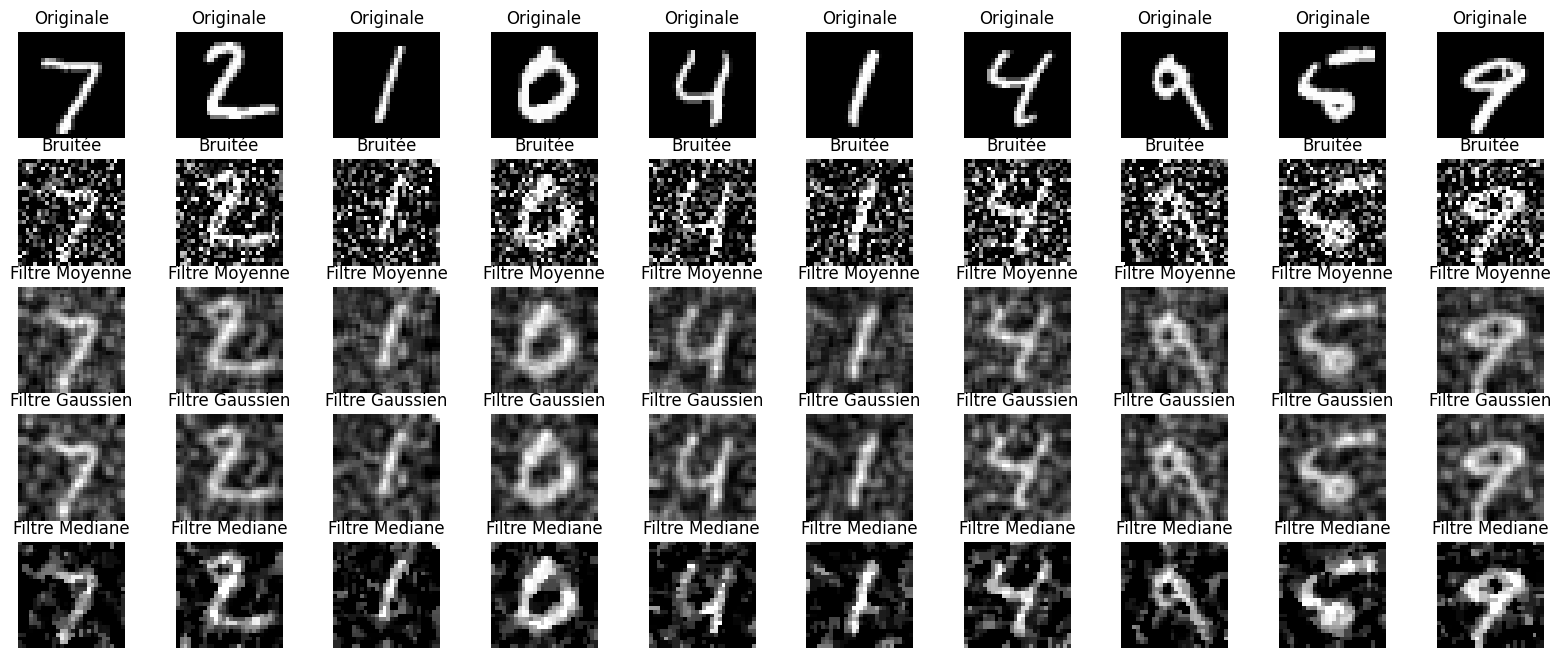

In [6]:
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 8))
for i in range(n):
    # Images originales
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Originale")
    plt.axis('off')

    # Images bruitées
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(noisy_test[i].reshape(28, 28), cmap='gray')
    plt.title("Bruitée")
    plt.axis('off')

    # Images débruitées par le filtre de Moyenne
    ax = plt.subplot(5, n, i + 1 + 2 * n)
    plt.imshow(mean_filtered_test[i].reshape(28, 28), cmap='gray')
    plt.title("Filtre Moyenne")
    plt.axis('off')

    # Images débruitées par le filtre Gaussien
    ax = plt.subplot(5, n, i + 1 + 3 * n)
    plt.imshow(gaussian_filtered_test[i].reshape(28, 28), cmap='gray')
    plt.title("Filtre Gaussien")
    plt.axis('off')

    # Images débruitées par le filtre Mediane
    ax = plt.subplot(5, n, i + 1 + 4 * n)
    plt.imshow(median_filtered_test[i].reshape(28, 28), cmap='gray')
    plt.title("Filtre Mediane")
    plt.axis('off')

plt.show()

# **Évaluation Quantitative des Filtrages**

Interprétation des résultats PSNR :

-Filtre Moyenne (12.28) :
Offre une réduction basique du bruit, mais floute significativement les contours, ce qui impacte la qualité de reconstruction.

-Filtre Gaussien (12.43) :
Légèrement meilleur que le filtre de moyenne grâce à sa pondération gaussienne, qui préserve un peu mieux les détails.

-Filtre Médian (14.20) :
Donne les meilleurs résultats, car il supprime efficacement le bruit impulsionnel tout en conservant les contours nets, ce qui améliore la fidélité vis-à-vis des images originales.

In [7]:
# Assurez-vous que toutes les données sont en float32
mean_filtered_test = mean_filtered_test.astype('float32')
gaussian_filtered_test = gaussian_filtered_test.astype('float32')

# Calcul du PSNR
psnr_mean = np.mean([psnr(x_test[i], mean_filtered_test[i], data_range=1.0) for i in range(len(x_test))])
psnr_gaussian = np.mean([psnr(x_test[i], gaussian_filtered_test[i], data_range=1.0) for i in range(len(x_test))])
psnr_median = np.mean([psnr(x_test[i], median_filtered_test[i], data_range=1.0) for i in range(len(x_test))])

print(f"PSNR - Filtre Moyenne: {psnr_mean:.2f}")
print(f"PSNR - Filtre Gaussien: {psnr_gaussian:.2f}")
print(f"PSNR - Filtre Mediane: {psnr_median:.2f}")


PSNR - Filtre Moyenne: 12.28
PSNR - Filtre Gaussien: 12.42
PSNR - Filtre Mediane: 14.19


Conclusion :

Le filtre médian est clairement le plus performant selon le PSNR (14.20), offrant un excellent compromis entre réduction du bruit et préservation des détails. C'est le choix recommandé pour ce type de données bruitées.

# **Construction de l'Autoencodeur**

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

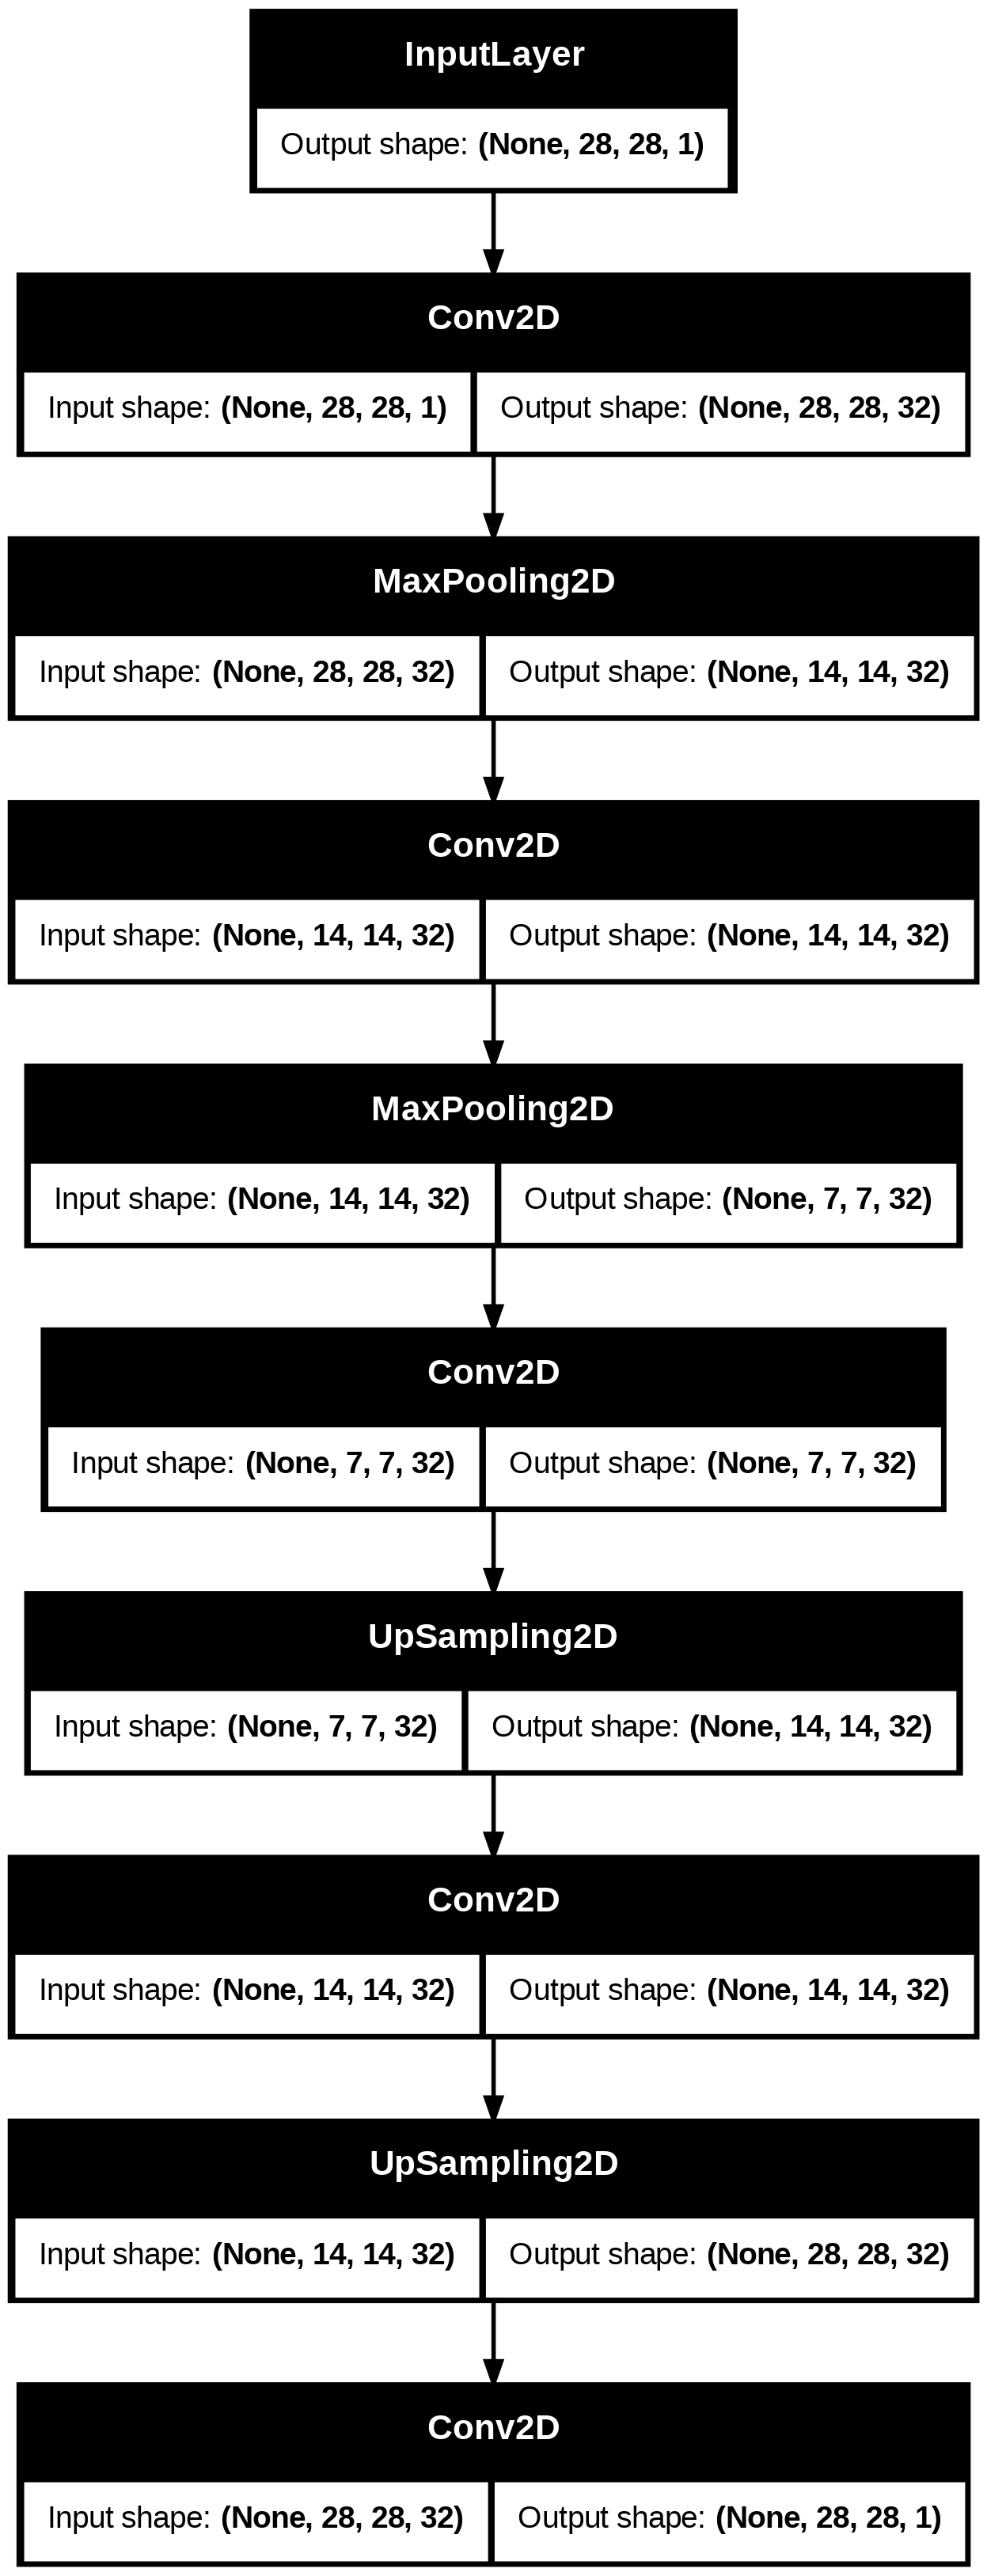

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Couche d'entrée
input_img = Input(shape=(28, 28, 1))

# **Encodeur**
x = Conv2D(32, (3, 3), activation='relu', padding='same' )(input_img)  # Output: (28, 28, 32)
x = MaxPooling2D((2, 2), padding='same')(x)                       # Output: (14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)           # Output: (14, 14, 32)
x = MaxPooling2D((2, 2), padding='same')(x)                      # Output: (7, 7, 32)

# **Goulot d'étranglement**
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)           # Output: (7, 7, 32)

# **Décodeur**
x = UpSampling2D((2, 2))(x)                                      # Output: (14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)           # Output: (14, 14, 32)
x = UpSampling2D((2, 2))(x)                                      # Output: (28, 28, 32)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output: (28, 28, 1)

# Construction du modèle
autoencoder = Model(input_img, decoded)
autoencoder.summary()

# Visualiser le modèle avec TensorBoard
plot_model(autoencoder, to_file='Auto-Encoder.png', show_shapes=True)

# **Configure le processus d'entraînement du modèle**

In [23]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# **Entraînement**

In [24]:
# Entraînement
history = autoencoder.fit(noisy_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,  #les données d'entraînement seront mélangées (ou réordonnées aléatoirement) à chaque époque
                          validation_data=(noisy_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.3351 - val_loss: 0.1310
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1269 - val_loss: 0.1168
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1167 - val_loss: 0.1113
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1121 - val_loss: 0.1083
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1090 - val_loss: 0.1063
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1073 - val_loss: 0.1050
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1060 - val_loss: 0.1043
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1047 - val_loss: 0.1029
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1038 - val_loss: 0.1019
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1027 - val_loss: 0.1011
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1022 - val_loss: 0.1007
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/st

# **Visualisation des Résultats**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


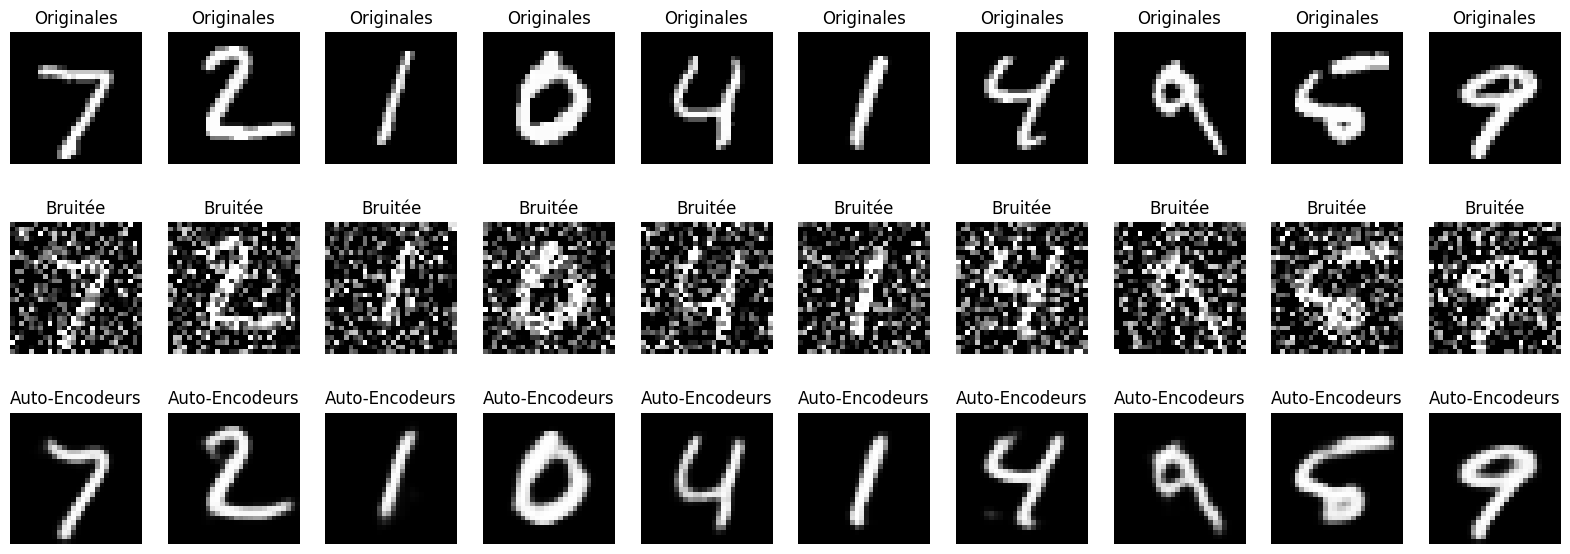

In [25]:
# Prédiction
decoded_imgs = autoencoder.predict(noisy_test)

# Visualisation
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 7))
for i in range(n):

    # Images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Originales")
    plt.axis('off')

    # Images bruitées
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_test[i].reshape(28, 28), cmap='gray')
    plt.title("Bruitée")
    plt.axis('off')



    # Images débruitées par Auto-Encodeurs
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Auto-Encodeurs")
    plt.axis('off')


plt.show()

# **Évaluation Quantitative PSNR**

In [26]:
# Calcul du PSNR
psnr_values = [psnr(x_test[i], decoded_imgs[i]) for i in range(len(x_test))]
print(f"PSNR moyen: {np.mean(psnr_values):.2f}")

PSNR moyen: 20.18


# **Exportation du Modèle**

In [27]:
# Sauvegarde du modèle
autoencoder.save("autoencoder_denoising.h5")

# **Construction de l'Autoencodeur Avancé N1**

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

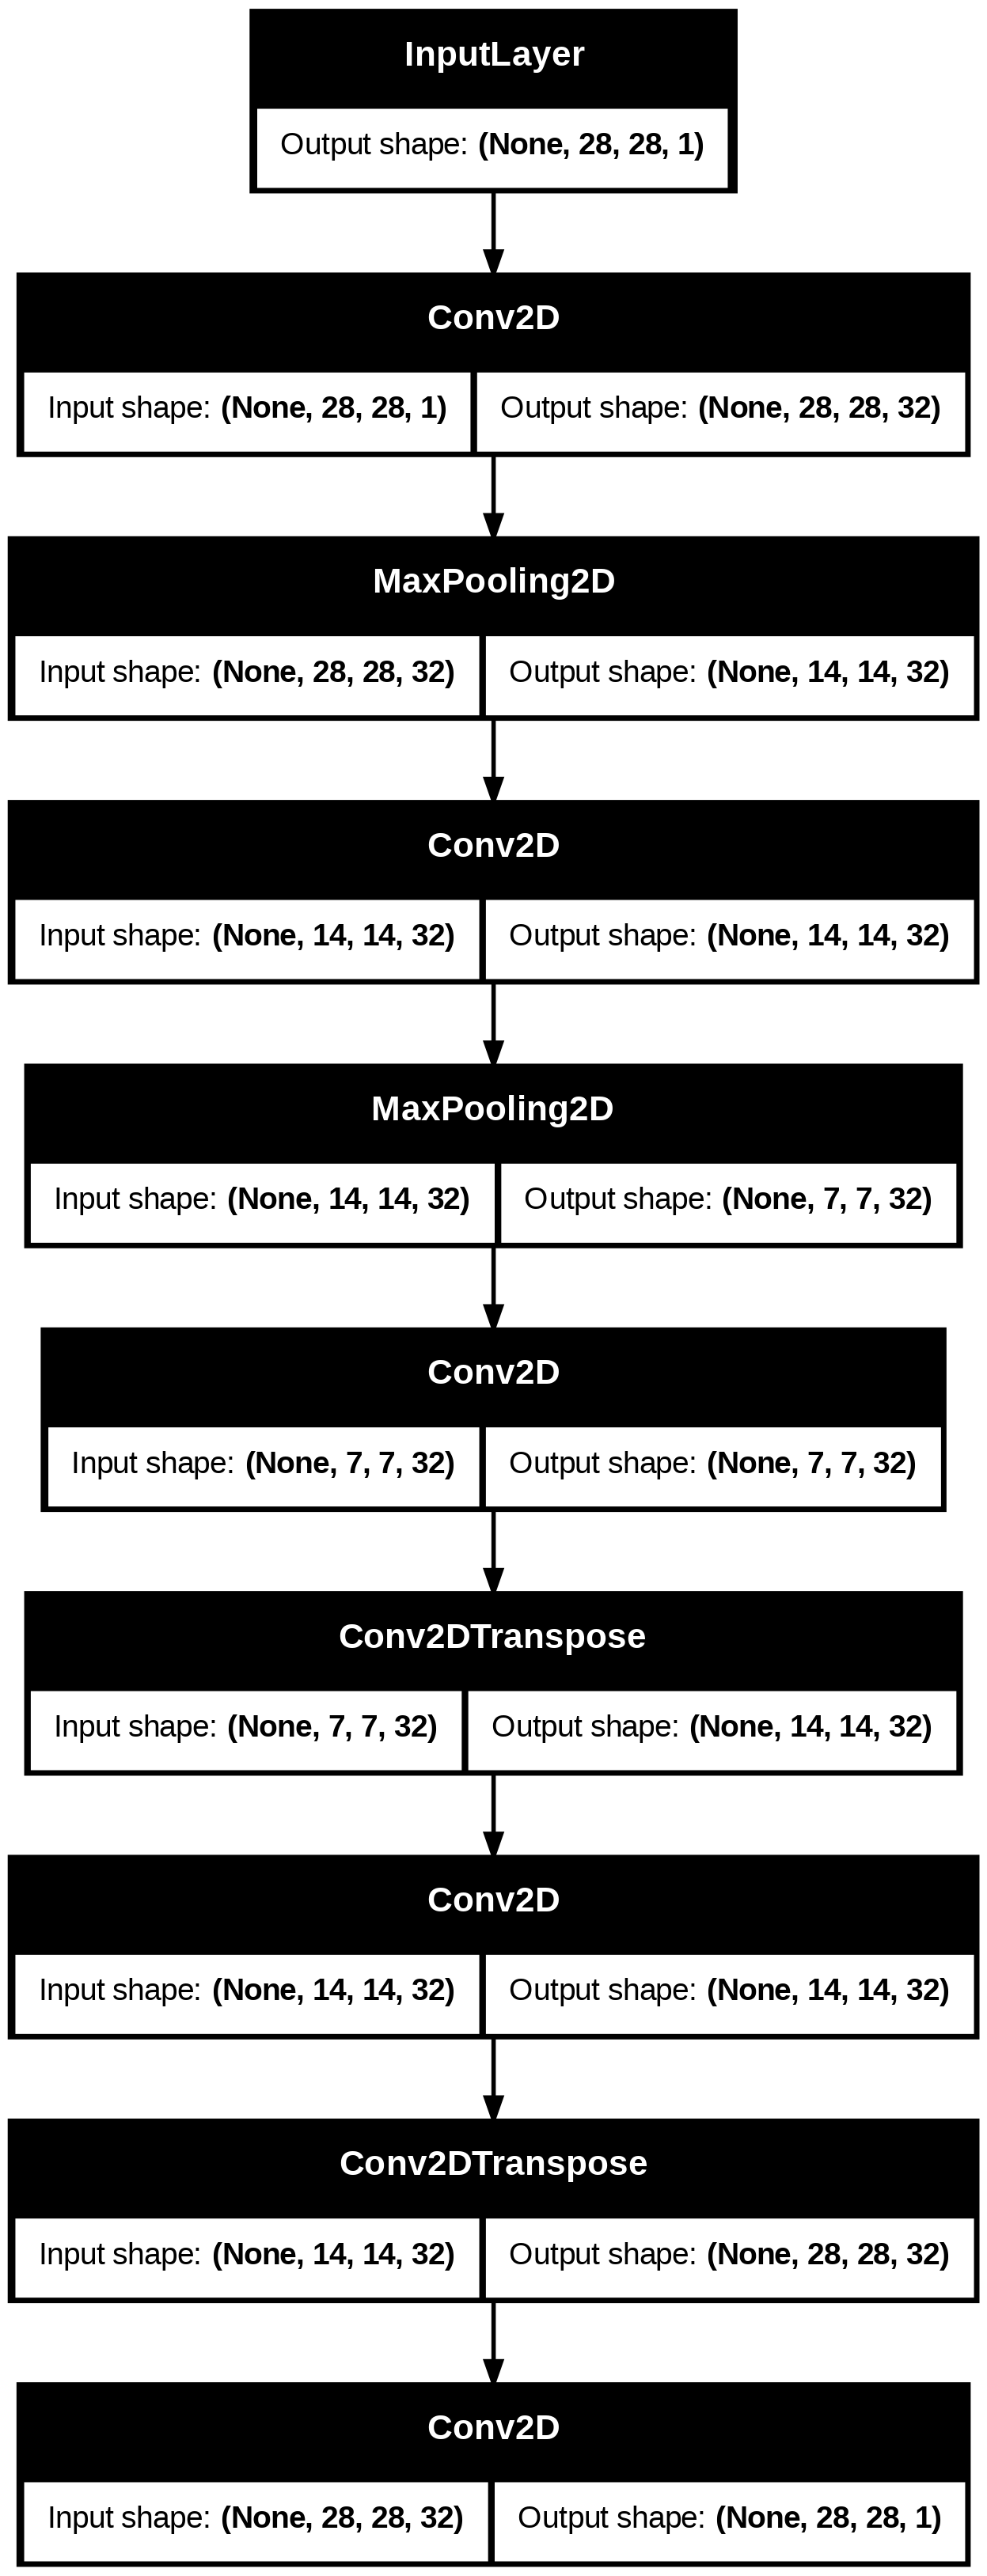

In [28]:
# Couche d'entrée
input_img = Input(shape=(28, 28, 1))

# **Encodeur**
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # Output: (28, 28, 32)
x = MaxPooling2D((2, 2), padding='same')(x)  # Output: (14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Output: (14, 14, 32)
x = MaxPooling2D((2, 2), padding='same')(x)  # Output: (7, 7, 32)

# **Goulot d'étranglement**
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Output: (7, 7, 32)

# **Décodeur**
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)  # Output: (14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Output: (14, 14, 32)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)  # Output: (28, 28, 32)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output: (28, 28, 1)

# Construction du modèle
autoencoder2 = Model(input_img, decoded)

# Afficher un résumé du modèle
autoencoder2.summary()

# Visualiser le modèle avec TensorBoard
plot_model(autoencoder2, to_file='Auto-Encoder.png', show_shapes=True)


# **Configure le processus d'entraînement du modèle**

In [29]:
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

# **Entraînement**

In [30]:
# Entraînement
history = autoencoder2.fit(noisy_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True, #  les données d'entraînement seront mélangées (ou réordonnées aléatoirement) à chaque époque
                          validation_data=(noisy_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.3605 - val_loss: 0.1264
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1228 - val_loss: 0.1118
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1120 - val_loss: 0.1071
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1077 - val_loss: 0.1046
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1055 - val_loss: 0.1027
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1037 - val_loss: 0.1016
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1025 - val_loss: 0.1006
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1016 - val_loss: 0.0996
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1005 - val_loss: 0.0990
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0997 - val_loss: 0.0983
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0991 - val_loss: 0.0984
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

# **Visualisation des Résultats**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


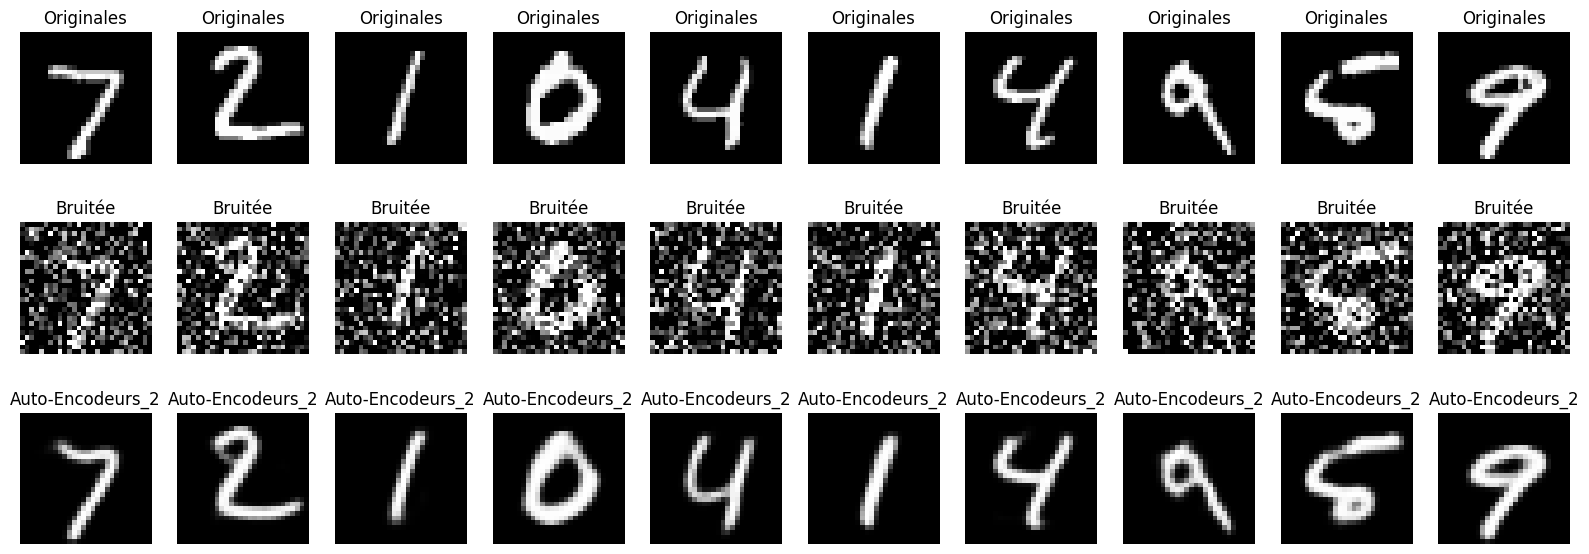

In [31]:
# Prédiction
decoded_imgs_2 = autoencoder2.predict(noisy_test)

# Visualisation
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 7))
for i in range(n):

    # Images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Originales")
    plt.axis('off')

    # Images bruitées
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_test[i].reshape(28, 28), cmap='gray')
    plt.title("Bruitée")
    plt.axis('off')



    # Images débruitées par Auto-Encodeurs
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs_2[i].reshape(28, 28), cmap='gray')
    plt.title("Auto-Encodeurs_2")
    plt.axis('off')


plt.show()

# **Évaluation Quantitative PSNR**

In [32]:
# Calcul du PSNR
psnr_values = [psnr(x_test[i], decoded_imgs_2[i]) for i in range(len(x_test))]
print(f"PSNR moyen: {np.mean(psnr_values):.2f}")

PSNR moyen: 20.42


# **Exportation du Modèle**

In [38]:
# Sauvegarde du modèle
autoencoder2.save("autoencoder_denoising_2.h5")

# **Construction de l'Autoencodeur Avancé N2**

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 28, 28, 64)     │            640 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 28, 28, 64)     │         36,928 │ conv2d_67[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 28, 28, 64)     │            256 │ conv2d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 14, 14, 64)     │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 14, 14, 128)    │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 14, 14, 128)    │        147,584 │ conv2d_69[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 14, 14, 128)    │        147,584 │ conv2d_70[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 14, 14, 128)    │            512 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 7, 7, 128)      │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 7, 7, 128)      │        147,584 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 7, 7, 128)      │        147,584 │ conv2d_72[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 7, 7, 128)      │        147,584 │ conv2d_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_14       │ (None, 14, 14, 128)    │        147,584 │ conv2d_74[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 14, 14, 128)    │            512 │ conv2d_transpose_14[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 14, 14, 128)    │        147,584 │ batch_normalization_1… │
├──────────────────────

 Total params: 1,450,785 (5.53 MB)

 Trainable params: 1,450,017 (5.53 MB)

 Non-trainable params: 768 (3.00 KB)

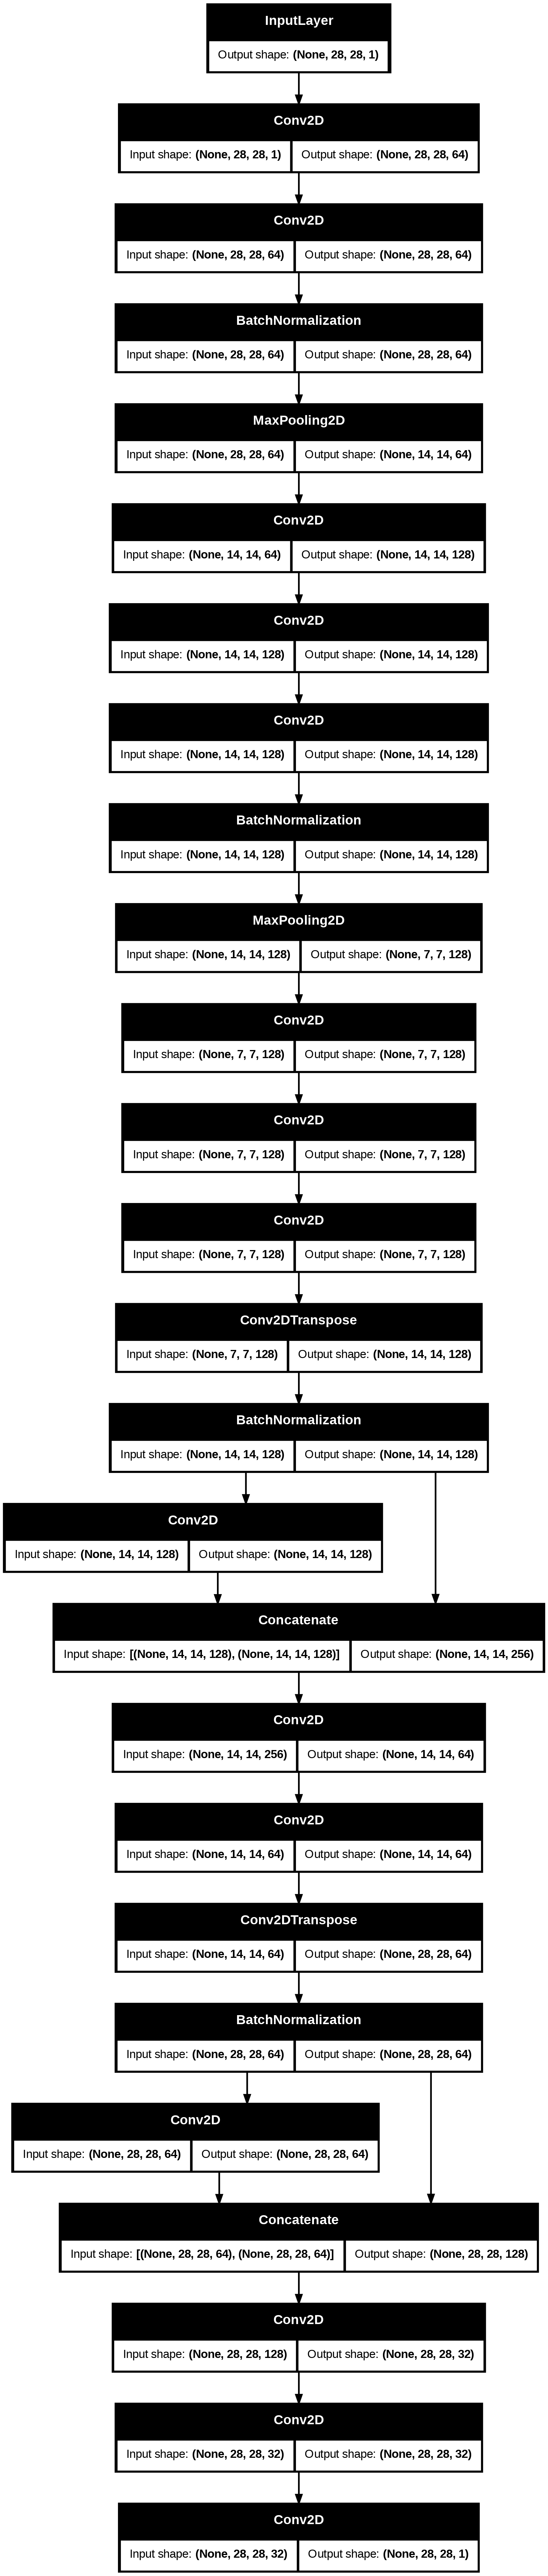

In [40]:
# Couche d'entrée
input_img = Input(shape=(28, 28, 1))

# **Encodeur**
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)  # Output: (28, 28, 64)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Output: (28, 28, 64)
x = BatchNormalization()(x)  # Normalisation
x = MaxPooling2D((2, 2), padding='same')(x)  # Output: (14, 14, 64)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Output: (14, 14, 128)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Output: (14, 14, 128)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Output: (14, 14, 128)
x = BatchNormalization()(x)  # Normalisation
x = MaxPooling2D((2, 2), padding='same')(x)  # Output: (7, 7, 128)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Output: (7, 7, 128)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Output: (7, 7, 128)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Output: (7, 7, 128)

# **Décodeur**
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)  # Output: (14, 14, 128)
x = BatchNormalization()(x)  # Normalisation
x = Concatenate()([x, Conv2D(128, (3, 3), activation='relu', padding='same')(x)])  # Concatenate with previous feature map

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Output: (14, 14, 64)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Output: (14, 14, 64)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)  # Output: (28, 28, 64)
x = BatchNormalization()(x)  # Normalisation
x = Concatenate()([x, Conv2D(64, (3, 3), activation='relu', padding='same')(x)])  # Concatenate with previous feature map

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Output: (28, 28, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Output: (28, 28, 32)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output: (28, 28, 1)

# Construction du modèle
autoencoder3 = Model(input_img, x)

# Afficher un résumé du modèle
autoencoder3.summary()


# Visualiser le modèle avec TensorBoard
plot_model(autoencoder3, to_file='Auto-Encoder3.png', show_shapes=True)

# **Configure le processus d'entraînement du modèle**

In [41]:
autoencoder3.compile(optimizer='adam', loss='binary_crossentropy')

# **Entraînement**

In [42]:
# Entraînement
history = autoencoder3.fit(noisy_train, x_train,
                          epochs=20,
                          batch_size=256,
                          shuffle=True, #  les données d'entraînement seront mélangées (ou réordonnées aléatoirement) à chaque époque
                          validation_data=(noisy_test, x_test))

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 53s 161ms/step - loss: 0.1888 - val_loss: 0.2164
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 61s 115ms/step - loss: 0.0953 - val_loss: 0.1381
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - loss: 0.0923 - val_loss: 0.0920
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - loss: 0.0905 - val_loss: 0.0919
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - loss: 0.0897 - val_loss: 0.0904
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - loss: 0.0890 - val_loss: 0.0915
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - loss: 0.0882 - val_loss: 0.0945
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - loss: 0.0876 - val_loss: 0.0943
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - loss: 0.0870 - val_loss: 0.0894
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - loss: 0.0866 - val_loss: 0.0899
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - loss: 0.0856 - val_loss: 0.0957
Epoch 12/20
235/235

# **Visualisation des Résultats**

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


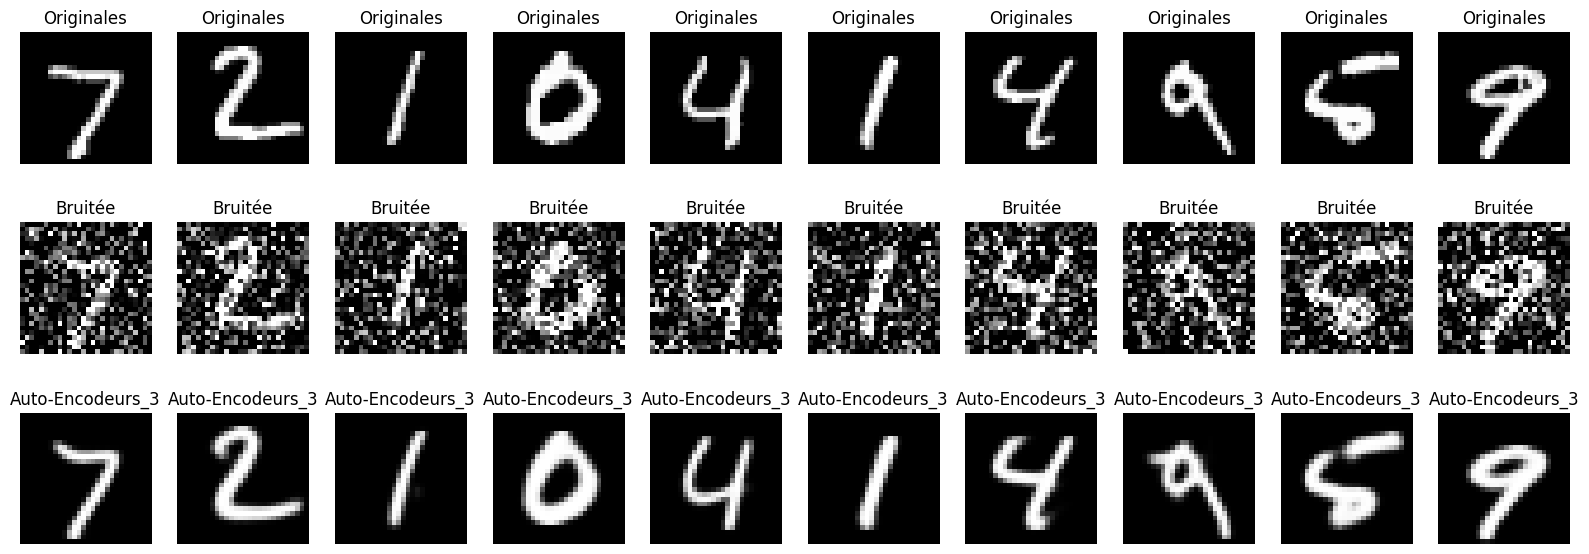

In [43]:
# Prédiction
decoded_imgs_3 = autoencoder3.predict(noisy_test)

# Visualisation
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 7))
for i in range(n):

    # Images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Originales")
    plt.axis('off')

    # Images bruitées
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_test[i].reshape(28, 28), cmap='gray')
    plt.title("Bruitée")
    plt.axis('off')



    # Images débruitées par Auto-Encodeurs
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs_3[i].reshape(28, 28), cmap='gray')
    plt.title("Auto-Encodeurs_3")
    plt.axis('off')


plt.show()

# **Évaluation Quantitative PSNR**

In [44]:
# Calcul du PSNR
psnr_values = [psnr(x_test[i], decoded_imgs_3[i]) for i in range(len(x_test))]
print(f"PSNR moyen: {np.mean(psnr_values):.2f}")

PSNR moyen: 19.94


# **Exportation du Modèle**

In [48]:
# Sauvegarde du modèle
autoencoder3.save("autoencoder3_denoising_3.h5")

# **Comparaison des resultats des trois modèles**

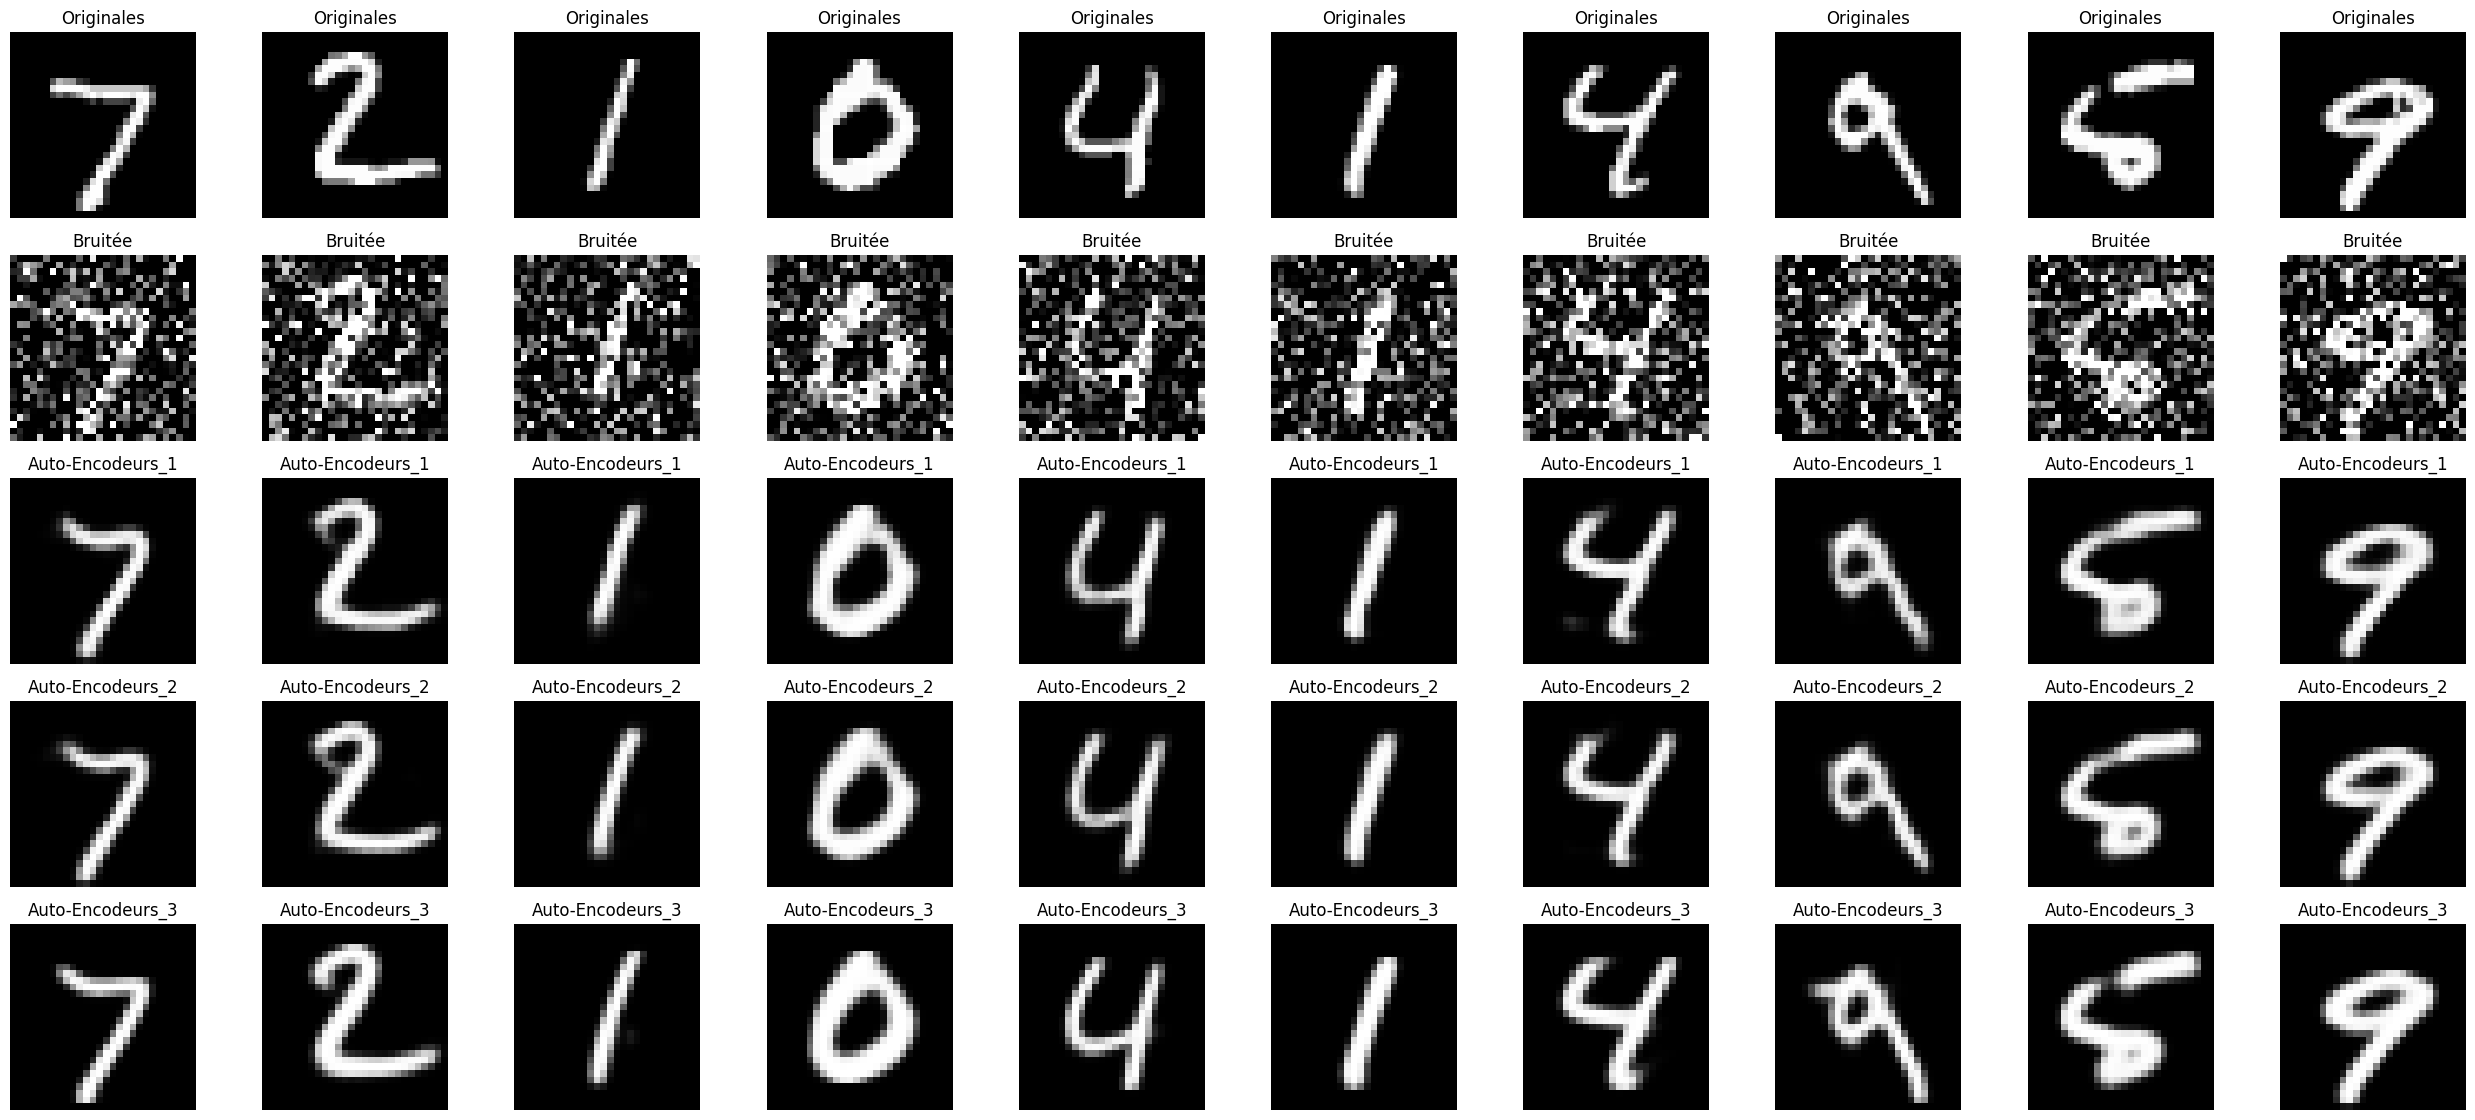

In [46]:
# Visualisation
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(32, 14))
for i in range(n):

    # Images originales
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Originales")
    plt.axis('off')

    # Images bruitées
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(noisy_test[i].reshape(28, 28), cmap='gray')
    plt.title("Bruitée")
    plt.axis('off')

    ax = plt.subplot(5, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Auto-Encodeurs_1")
    plt.axis('off')

    ax = plt.subplot(5, n, i + 1 + 3 * n)
    plt.imshow(decoded_imgs_2[i].reshape(28, 28), cmap='gray')
    plt.title("Auto-Encodeurs_2")
    plt.axis('off')

    ax = plt.subplot(5, n, i + 1 + 4 * n)
    plt.imshow(decoded_imgs_3[i].reshape(28, 28), cmap='gray')
    plt.title("Auto-Encodeurs_3")
    plt.axis('off')


plt.show()